In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pickle
from scipy.optimize import minimize
import spin_package.ising_fixed_T as ising_T
import spin_package.utils as sp_utils

%load_ext autoreload
%autoreload 2

In [2]:
def linear(x, a,b):
    return a * x + b

## State Following Fixed Temperatures

In [ ]:
p = 3
n_points_m = 100
n_points_less_T = 1
n_points_T = 2
n_points_more_T = 0

T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="ising")

Teqs = np.hstack(
    (
        (T_kauz - (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_less_T + 1))[::-1],
        np.linspace(T_kauz, T_dyn, n_points_T + 1),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)
T_planting = T_kauz
J0 = 0.5 / T_planting

m2i = 0.9
q2i = 0.9

In [29]:
ms = np.linspace(0.0, 0.9, n_points_m)
q_old = 0.9
all_data = {}

for jdx, T in enumerate(tqdm(Teqs, desc="RS")):
    data = sp_utils.observables(["q", "m", "f", "h"], (n_points_m,))
    total_file_name = "../data/ising/" + sp_utils.get_file_name_T_sweep_m(
        "ising", p, T_planting, T, ms
    )
    if os.path.exists(total_file_name):
        with open(total_file_name, "rb") as f:
            data = pickle.load(f)
    else:
        for idx, m in enumerate(tqdm(ms, desc="m", leave=False)):
            h, q = ising_T.fixed_points_h_q_T(m, T, p, J0, blend=0.95, q_init=q_old)

            data["q"][idx] = q
            data["h"][idx] = h
            data["m"][idx] = m
            data["f"][idx] = ising_T.f_FP_T(m, q, h, p, T, J0)

            q_old = q

        with open(total_file_name, "wb") as f:
            pickle.dump(data, f)

    all_data[T] = data

print("Data is saved.")

RS:   0%|          | 0/4 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

m:   0%|          | 0/100 [00:00<?, ?it/s]

Data is saved.


In [48]:
m0, q0, h0 = 0.9, 0.9, 0.9
blend = 0.1
total_file_name = "../data/ising/" + sp_utils.get_file_name_sweep_T(
    "ising", p, T_planting, Teqs, m0, q0
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_fixed_point = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    data_fixed_point = sp_utils.observables(["T", "q", "m", "f", "e"], (len(Teqs),))
    for i, T in enumerate(tqdm(Teqs)):
        m, q, h = m0, q0, h0
        err = 1
        while err > 1e-7:
            m_new = ising_T.compute_m_standard(m, q, p, 1 / T, J0)
            q_new = ising_T.compute_q_standard(m, q, p, 1 / T, J0)

            err = max(abs(q_new - q), abs(m_new - m))
            m = blend * m + (1 - blend) * m_new
            q = blend * q + (1 - blend) * q_new

        data_fixed_point["T"][i] = T
        data_fixed_point["m"][i] = m
        data_fixed_point["q"][i] = q
        data_fixed_point["f"][i] = ising_T.compute_free_energy_standard(
            m, q, p, 1 / T, J0
        )
        data_fixed_point["e"][i] = ising_T.compute_energy_standard(m, q, p, 1 / T, J0)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_fixed_point, f)

    print("Data is saved.")

Data is not saved.


  0%|          | 0/4 [00:00<?, ?it/s]

Data is saved.


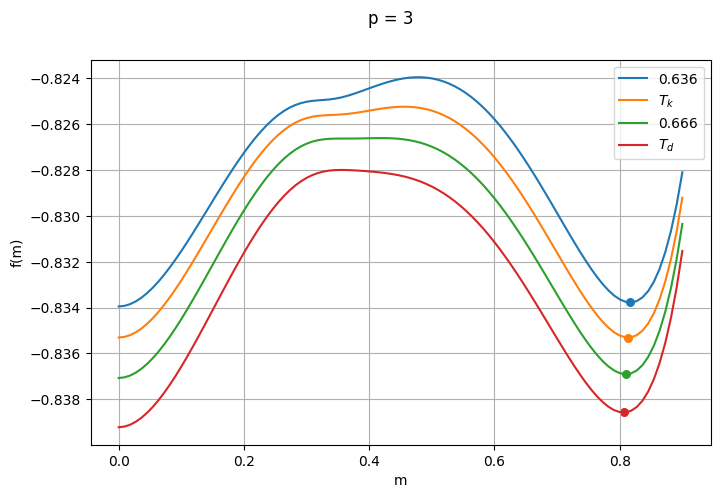

In [47]:
plt.figure(figsize=(8,5))
plt.suptitle(f"p = {p:d}")
for i, T in enumerate(Teqs):
    legend_name = sp_utils.legend_name_Tk_Td_T(T, T_kauz, T_dyn)

    data = all_data[T]
    plt.plot(data['m'], data['f'], label=legend_name, color=f'C{i}')

    plt.scatter(data_fixed_point['m'][i], data_fixed_point['f'][i], color=f'C{i}', marker='o', s=30)

plt.xlabel('m')
plt.ylabel(r'f(m)')
plt.legend()
plt.grid()


## State Following Untill Losing

In [ ]:
p = 3
T_kauz, T_dyn = sp_utils.get_Tk_Td(p, model="ising")
T_planting = T_kauz
J0 = 0.5 / T_planting

Teqs = np.hstack(
    (
        (T_kauz - (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_less_T + 1))[::-1],
        np.linspace(T_kauz, T_dyn, n_points_T + 1),
        T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1),
    )
)

T_start = T_kauz
deltaT = 0.005
m0, q0 = 0.9, 0.9

In [ ]:
blend = 0.4
total_file_name = "../data/ising/" + sp_utils.get_file_name_until_fail(
    "ising", p, T_planting, T_start, deltaT, m0, q0
)
if os.path.exists(total_file_name):
    print("Data is already saved.")
    with open(total_file_name, "rb") as f:
        data_fixed_point = pickle.load(f)

    print("Data is loaded.")
else:
    print("Data is not saved.")
    tmp_T, tmp_m, tmp_q, tmp_f, tmp_e = [], [], [], [], []
    cur_T = T_start
    m, q = m0, q0
    while True:
        print(f"T = {cur_T:.3f}")
        err = 1
        while err > 1e-7:
            m_new = ising_T.compute_m_standard(m, q, p, 1 / cur_T, J0)
            q_new = ising_T.compute_q_standard(m, q, p, 1 / cur_T, J0)

            err = max(abs(q_new - q), abs(m_new - m))
            m = blend * m + (1 - blend) * m_new
            q = blend * q + (1 - blend) * q_new

        if abs(m) < 1e-7:
            break
        else:
            tmp_T.append(cur_T)
            tmp_m.append(m)
            tmp_q.append(q)
            tmp_f.append(ising_T.compute_free_energy_standard(m, q, p, 1 / cur_T, J0))
            tmp_e.append(ising_T.compute_energy_standard(m, q, p, 1 / cur_T, J0))

            cur_T += deltaT

    data_fixed_point = sp_utils.observables(["T", "q", "m", "f", "e"], (len(tmp_T),))
    data_fixed_point["T"] = np.array(tmp_T)
    data_fixed_point["m"] = np.array(tmp_m)
    data_fixed_point["q"] = np.array(tmp_q)
    data_fixed_point["f"] = np.array(tmp_f)
    data_fixed_point["e"] = np.array(tmp_e)

    with open(total_file_name, "wb") as f:
        pickle.dump(data_fixed_point, f)

    print("Data is saved.")

Data is already saved.
Data is loaded.
